# Graphs and Networks in Linear Algebra

This notebook is based on section 10.1 of Strang's *Linear Algebra* textbook.

One interesting source of large matrices in linear algebra is a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics), a collection of *nodes* (vertices) and *edges* (arrows from one vertex to another).   Graphs are used in many applications to represent *relationships* and *connectivity*, such as:

* For computer networks, nodes could represent web pages, and edges could represent links.
* For circuits, edges could represent wires (or resistors) and nodes junctions.
* For transportation, nodes could represent cities and edges roads.
* In bioinformatics, graphs can represent gene regulatory networks.
* In sociology, nodes could represent people and edges relationships.
* ... and many, many other applications ...

In this notebook, we explain how a graph can be represented by a *matrix*, and how linear algebra can tell us properties of the graph and can help us do computations on graph-based problems.  There is a particularly beautiful connection to Kirchhoff's laws of circuit theory.

## Packages for this notebook

To run the code in this notebook, you'll need to install a few Julia packages used below.  To do so, uncomment the following line and run it:

In [1]:
# Pkg.add.(["GraphViz", "RowEchelon", "Interact", "SymPy"])

...and then run this cell to import the packages:

In [2]:
using Interact, RowEchelon, Compat
import GraphViz
import SymPy.Sym

## Julia Graph-visualization code

There are several Julia packages for manipulating graphs, e.g. [LightGraphs](https://github.com/JuliaGraphs/LightGraphs.jl), along with several packages for visualizing graphs, e.g. [GraphViz](https://github.com/Keno/GraphViz.jl).  LightGraphs is oriented towards fast and sophisticated graph computations, however, and here I just want to do some simple and pretty visualizations with simple algorithms based on those in Strang's 18.06 textbook.

So, here I define a simple `DiGraph` datastructure for directed graphs, oriented towards visualization via the GraphViz package (allowing me to control colors and other properties easily).   18.06 students can skip over all of this code directly to the results.

In [3]:
# A very simple data structure representing a directed graph, with the ability to
# label and color the nodes and edges as needed.
const Properties = Dict{Symbol,Any}
immutable DiNode
    label::Any
    props::Properties
    DiNode(label, props::Properties) = new(label, props)
    DiNode(label, props::Pair{Symbol}...) = DiNode(label, Properties(props...))
end
Base.copy(n::DiNode) = DiNode(n.label, copy(n.props))
immutable DiEdge
    e::Pair{Int,Int}
    props::Properties
    DiEdge(e, props::Properties) = new(e, props)
    DiEdge(e, props::Pair{Symbol}...) = DiEdge(e, Properties(props...))
end
Base.copy(e::DiEdge) = DiEdge(e.e, copy(e.props))
type DiGraph
    nodes::Vector{DiNode}
    edges::Vector{DiEdge}
    props::Properties # properties of the whole graph
    function DiGraph(nodes::Vector{DiNode}, edges::Vector{DiEdge}, props::Properties)
        n = length(nodes)
        all(e -> minimum(e.e) ≥ 1 && maximum(e.e) ≤ n, edges) || throw(ArgumentError("edge refers to nonexistent node"))
        new(nodes, edges, props)
    end
    DiGraph(nodes::Vector{DiNode}, edges::Vector{DiEdge}, props::Pair{Symbol}...) =
        DiGraph(nodes, edges, Properties(props...))
end
function DiGraph(numnodes::Integer, edges::Pair{Int,Int}...)
    n = Int(numnodes)
    m = length(edges)
    DiGraph([DiNode(i) for i=1:n], [DiEdge(edges[j], :label=>j) for j=1:m])
end
DiGraph(edges::Pair{Int,Int}...) = DiGraph(maximum(e -> maximum(e), edges), edges...)
Base.copy(g::DiGraph) = DiGraph(copy.(g.nodes), copy.(g.edges), copy(g.props))
function nodecolors!(g::DiGraph, nodes::AbstractVector{Int}, color::String="red")
    for n in nodes
        g.nodes[n].props[:color] = color
        g.nodes[n].props[:fontcolor] = color
    end
    g
end
nodecolors(g::DiGraph, nodes::AbstractVector{Int}, color::String="red") = nodecolors!(copy(g), nodes, color)
function edgecolors!(g::DiGraph, edges::AbstractVector{Int}, color::String="red")
    for e in edges
        g.edges[e].props[:color] = color
        g.edges[e].props[:fontcolor] = color
    end
    g
end
edgecolors(g::DiGraph, edges::AbstractVector{Int}, color::String="red") = edgecolors!(copy(g), edges, color)
function edgelen!(g::DiGraph, len::Real=1)
    for e in g.edges
        e.props[:len] = len
    end
    g
end
function labels!(g::DiGraph; edges=nothing, nodes=nothing)
    if edges !== nothing
        for (e,E) in zip(g.edges, edges)
            e.props[:label] = E
        end
    end
    if nodes !== nothing
        for (n,N) in zip(g.nodes, nodes)
            n.props[:label] = N
        end
    end
    g
end
labels(g::DiGraph; kws...) = labels!(copy(g); kws...)

labels (generic function with 1 method)

In [4]:
# visualization of DiGraph via GraphViz
function showprop(io, x::String)
    print(io, '"')
    escape_string(io, x, "")
    print(io, '"')
end
showprop(io, x::Number) = print(io, x)
showprop(io, x) = showprop(io, string(x))
GraphViz.Graph(g::DiGraph) = GraphViz.Graph(DOTstring(g))
Base.show(io::IO, m::MIME"image/svg+xml", g::DiGraph) = show(io, m, GraphViz.Graph(g))

# convert g to a string in DOT format for use with GraphViz
function DOTstring(g::DiGraph)
    buf = IOBuffer()
    println(buf, "digraph MyDiGraph {")
    for (i,n) in enumerate(g.nodes)
        print(buf, "  ", i, " [label=")
        showprop(buf, n.label)
        for (p,v) in n.props
            print(buf, ' ', p, '=')
            showprop(buf, v)
        end
        print(buf, "]\n")
    end
    for (j,e) in enumerate(g.edges)
        print(buf, "  ", e.e.first, " -> ", e.e.second, " [")
        for (p,v) in e.props
            print(buf, ' ', p, '=')
            showprop(buf, v)
        end
        print(buf, "]\n")
    end
    println(buf, "}")
    String(take!(buf))
end

DOTstring (generic function with 1 method)

In [5]:
# generate a random graph with a given average #edges per node
function randgraph(numnodes::Integer, edgespernode::Real)
    p = edgespernode/numnodes # probability of each edge
    e = Vector{Pair{Int,Int}}()
    for i = 1:numnodes, j = 1:numnodes
        if i != j && rand() < p
            push!(e, i=>j)
        end
    end
    return DiGraph(numnodes, e...)
end

randgraph (generic function with 1 method)

In [6]:
# returns the incidence matrix for g
function incidence(g::DiGraph)
    A = zeros(Int, length(g.edges), length(g.nodes))
    for (i,e) in enumerate(g.edges)
        A[i,e.e.first] = -1
        A[i,e.e.second] = 1
    end
    return A
end

incidence (generic function with 1 method)

In [7]:
# Find the loops in g by the simplest "textbook" manner:
# get a basis for the left nullspace incidence matrix.
# We do this via the rref form, rather than nullspace(A'), because
# we want a "nice" basis of ±1 and 0 entries.
function leftnullspace(g::DiGraph)
    A = incidence(g)
    R = rref(A')
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(R[i,:])
        j > 0 && push!(pivots, j)
    end
    r = length(pivots) # rank
    free = Int[j for j=1:n if j ∉ pivots]
    N = zeros(Int, n, n-r)
    k = 0
    for (k,j) in enumerate(free)
        N[pivots, k] = -R[1:r, j]
        N[j, k] = 1
    end
    return N
end

leftnullspace (generic function with 1 method)

In [8]:
# color the edges of a spanning tree of g, by the textbook
# method of finding the pivot rows of the incidence matrix
function pivotrows(g::DiGraph)
    A = incidence(g)
    R = rref(A')
    m, n = size(R)
    pivots = Int[]
    for i = 1:m
        j = findfirst(R[i,:])
        j > 0 && push!(pivots, j)
    end
    return pivots
end
colortree(g::DiGraph, color::String="red") = edgecolors(g, pivotrows(g), color)
tree(g::DiGraph) = DiGraph(copy.(g.nodes), g.edges[pivotrows(g)], copy(g.props))

tree (generic function with 1 method)

## Graphs and incidence matrices

Let's start by looking at an example graph with 6 nodes 8 edges.  Computers are pretty good at drawing graphs for us:

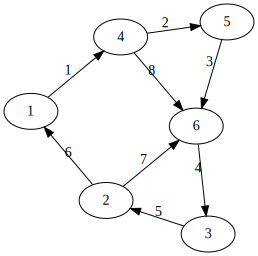

In [9]:
g = edgelen!(DiGraph(1=>4, 4=>5, 5=>6, 6=>3, 3=>2, 2=>1, 2=>6, 4=>6), 1.5)

A key way to represent a graph in linear algebra is the [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix).  As defined in Strang's textbook, this is a matrix where the **rows correspond to edges** and the **columns correspond to nodes**.  (Some authors use the transpose of this instead.)

In particular, in the row for each edge going **from node N to node M**, there is a **-1 in column N** and a **+1 in column N**.

For example, the incidence matrix of the graph above is:

In [10]:
A = incidence(g)

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  0   0   0  -1   1   0
  0   0   0   0  -1   1
  0   0   1   0   0  -1
  0   1  -1   0   0   0
  1  -1   0   0   0   0
  0  -1   0   0   0   1
  0   0   0  -1   0   1

There is an interesting structure if you think about *loops* in the graph.  For example, in the graph above there is a loop among nodes 6, 3, 2, via edges 4,5,7.  Let's look at the rows of $A$ corresponding to those edges:

In [11]:
A[[4,5,7],:]

3×6 Array{Int64,2}:
 0   0   1  0  0  -1
 0   1  -1  0  0   0
 0  -1   0  0  0   1

If we **add these rows** we get **zero**:

In [12]:
A[4,:]' + A[5,:]' + A[7,:]'

1×6 Array{Int64,2}:
 0  0  0  0  0  0

In general, it is easy to see that **any loop in the graph** corresponds to **dependent rows**: if we sum the rows going around the loop (with a minus sign for arrows in the wrong direction), we get zero.

The reason is simple: we get a -1 in a column when we *leave* a node, and a +1 in the column when we *enter* a node.  When we go around the loop, we leave and enter each node, so the sum is zero.

But dependent rows correspond to **elements of the left nullspace**:

In [13]:
[0 0 0 1 1 0 1 0] * A

1×6 Array{Int64,2}:
 0  0  0  0  0  0

That means that the number of "independent" (primitive) loops in a graph is related to the **rank** of the incidence matrix, and the **independent rows of A have no loops**.

Let's look at the row-reduced echelon (rref) form of $A^T$:

In [14]:
Matrix{Int}(rref(A'))

6×8 Array{Int64,2}:
 1  0  0  0  0  -1   0  0
 0  1  0  0  0  -1   0  1
 0  0  1  0  0  -1   0  1
 0  0  0  1  0  -1  -1  0
 0  0  0  0  1  -1  -1  0
 0  0  0  0  0   0   0  0

We can see that the rank of $A$ is 5:

In [15]:
rank(A)

5

This means that there are **five loop-free (independent) edges**, and there are **three** (8 - 5) primitive loops.  Using the rref form of $A^T$, we can read off a basis for the left nullspace from the free columns (6,7,8):

In [16]:
N = leftnullspace(g)

8×3 Array{Int64,2}:
 1  0   0
 1  0  -1
 1  0  -1
 1  1   0
 1  1   0
 1  0   0
 0  1   0
 0  0   1

Let's visualize these loops by plotting the edges in a different color (red) one by one,
with help from the Interact package to give us an interactive widget:

In [17]:
colorloop(g::DiGraph, n::Vector) = edgecolors!(edgecolors(g, find(n .> 0), "red"), find(n .< 0), "blue")
function animloops(g::DiGraph)
    L = leftnullspace(g)
    @manipulate for loop in 1:size(L,2)
        colorloop(g, L[:,loop])
    end
end

animloops (generic function with 1 method)

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(2, nactions=1),"loop",2,"2",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3),Dict(2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

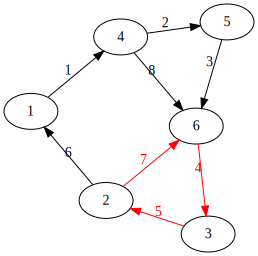

In [18]:
animloops(g)

These three loops are **not the only loops** in the graph, but the **other loops can be made from combinations of these loops**.  (Similarly, the columns of $N$ are not the *whole* left nullspace, they are just a **basis** for the n nullspace.

For example, the loop between nodes 1-4-6-2 can be made by starting with 1-4-5-6-3-2 and "subtracting" the 6-3-2 loop.

In this sense, a basis for the left nullspace of $A$ is a "basis" for the other loops in the graph: we say that they are "primitive" loops.

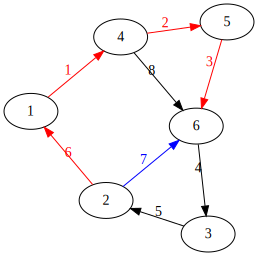

In [19]:
colorloop(g, N[:,1] - N[:,2]) # subtract two loops to make another loop

It is fun to do the same thing for bigger graphs, chosen at random:

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(6, nactions=1),"loop",6,"6",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

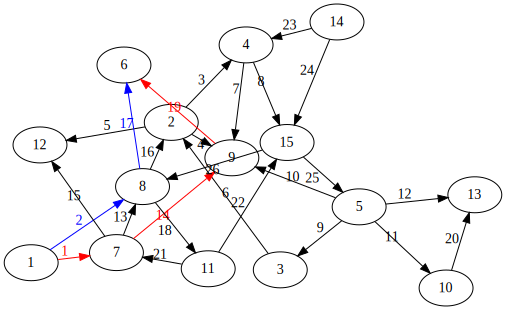

In [20]:
gbig = edgelen!(randgraph(15, 1.5), 1.5)
animloops(gbig)

Conversely, the *independent* rows of $A$ (corresponding to the **pivot columns** of the rref form of $A^T$) form a **maximal set of edges with no loops**.  A graph with no loops is called a [tree](https://en.wikipedia.org/wiki/Tree_(graph_theory)), and this particular tree is called a [spanning tree](https://en.wikipedia.org/wiki/Spanning_tree) because it touches all of ("spans") the nodes (assuming the graph is connected).

Let's color the spanning tree (loop-free edges) of our example graph red:

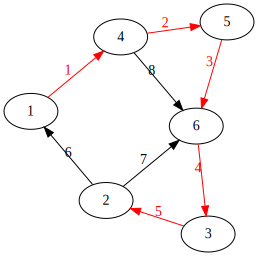

In [21]:
colortree(g)

We can also discard all of the edges that are *not* in the spanning tree, and we are left with a more boring graph of *just* the spanning tree:

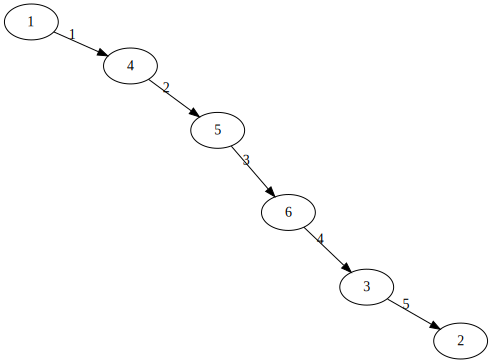

In [22]:
tree(g)

We can do the same thing for our bigger random example:

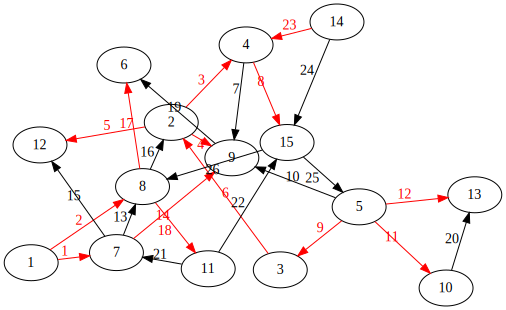

In [23]:
colortree(gbig)

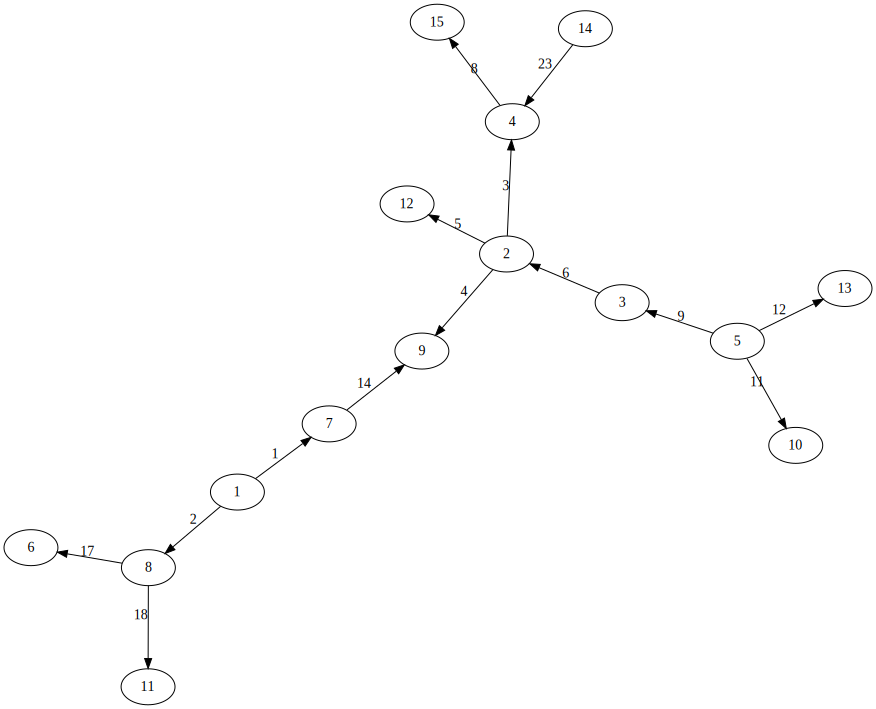

In [24]:
tree(gbig)

And we can make trees from even larger graphs, for fun:

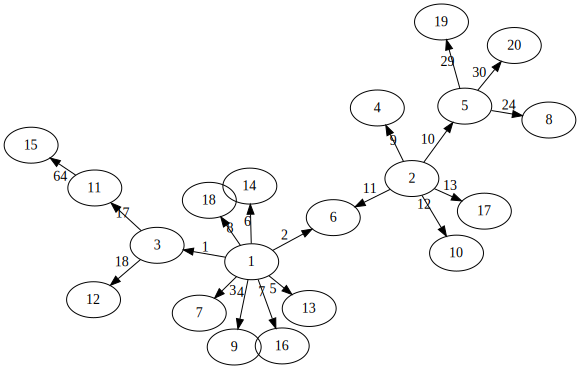

In [25]:
tree(randgraph(20, 6))

## Graphs and Kirchhoff's circuit laws



An elegant application of the incidence matrix and its subspaces arises if we think of the graph as representing an **electrical circuit**:

* Each edge represents a wire/resistor, with an unknown current $i$.  The *direction* of the edge indicates the *sign convention* ($i>0$ indicates current flowing in the direction of the arrow).
* Each node represents a junction, with an unknown voltage $v$.

Let's visualize this by re-labeling our graph from above.  We'll use the [SymPy](https://github.com/JuliaPy/SymPy.jl) package to allow us to do *symbolic* (not numeric) calculations with the incidence matrix.

In [26]:
# A little code so that we can label graph nodes/edges with SymPy expressions.
# convert strings like "v_2 - v_0" from SymPy to nicer Unicode strings like "v₂ - v₀"
subchar(d::Integer) = Char(UInt32('₀')+d)
subchar(c::Char) = subchar(UInt32(c)-UInt32('0'))
subchar(s::String) = replace(s, r"_[0-9]", s -> subchar(s[2]))
showprop(io, s::SymPy.Sym) = showprop(io, subchar(stringmime("text/plain", s)))
subchar("v_2 - v_0")

"v₂ - v₀"

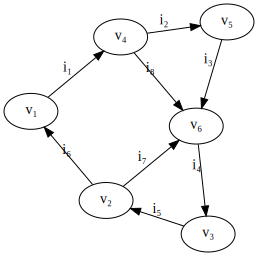

In [27]:
labels(g, edges=[Sym("i_$i") for i = 1:size(A,1)], nodes=[Sym("v_$i") for i = 1:size(A,2)])

### Kirchhoff's voltage law (KVL)

Let's start doing some linear algebra.  What happens if we *multiply* our incidence matrix $A$ by a vector of voltages, one per node?

In [28]:
v = [Sym("v_$i") for i = 1:size(A,2)]

6-element Array{SymPy.Sym,1}
[v_1]
[   ]
[v_2]
[   ]
[v_3]
[   ]
[v_4]
[   ]
[v_5]
[   ]
[v_6]

In [29]:
A

8×6 Array{Int64,2}:
 -1   0   0   1   0   0
  0   0   0  -1   1   0
  0   0   0   0  -1   1
  0   0   1   0   0  -1
  0   1  -1   0   0   0
  1  -1   0   0   0   0
  0  -1   0   0   0   1
  0   0   0  -1   0   1

In [30]:
A * v

8-element Array{SymPy.Sym,1}
[-v_1 + v_4]
[          ]
[-v_4 + v_5]
[          ]
[-v_5 + v_6]
[          ]
[v_3 - v_6 ]
[          ]
[v_2 - v_3 ]
[          ]
[v_1 - v_2 ]
[          ]
[-v_2 + v_6]
[          ]
[-v_4 + v_6]

What we get are the **voltage difference** across each edge.  It is easier to see this if we use the elements of $Av$ to directly label the edges of our graph:

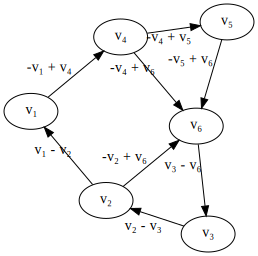

In [31]:
labels(g, edges=A*v, nodes=v)

Now, let's ask the inverse question: **what voltage differences $d=Av$** can possibly arise?  i.e. what $d$ are in $C(A)$? 

Remember, $A$ is **not full rank**: its rank is 5, but there are 8 rows (8 edges).  So, $C(A)$ is 5-dimensional ("missing" three dimensions).  Equivalently $C(A)$ is **orthogonal to the left nullspace**, which has three rows.  What does this mean?

Let's visualize the differences d:

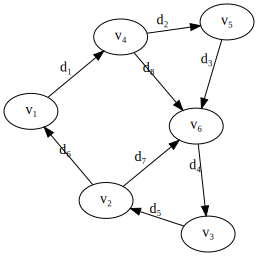

In [32]:
d = [Sym("d_$j") for j = 1:size(A,1)]
labels(g, edges=d, nodes=v)

If $N$ is a basis for the left nullspace, we must have $N^T d = 0$, or:

In [33]:
N' * d

3-element Array{SymPy.Sym,1}
[d_1 + d_2 + d_3 + d_4 + d_5 + d_6]
[                                 ]
[         d_4 + d_5 + d_7         ]
[                                 ]
[        -d_2 - d_3 + d_8         ]

But what is this?  Remember, each element of the left nullspace corresponded to a **loop in the graph**.  Saying $N^T d = 0$, or $d \perp N(A^T)$, is equivalent to saying that the **sum of the voltage drops around each loop = 0**.

But this is precisely [Kirchhoff's voltage law](https://en.wikipedia.org/wiki/Kirchhoff's_circuit_laws) from circuit theory!

### Kirchhoff's current law (KCL)

To actually solve circuit problems, we need three additional ingredients:

* The voltage difference $d$ must be divided by a resistance $R$ to get the *current* $i$ through that edge: $i = d/R = Yd$ (where $Y=1/R$ is the "admittance"), by [Ohm's law](https://en.wikipedia.org/wiki/Ohm's_law).

* The sum of the currents $i$ entering each node must be zero, by Kirchhoff's current law (KCL).

* To get a nontrivial solution, we need some kind of *source*: a battery or current source, to start currents flowing.

How do we represent each one of these steps by linear-algebra operations?

#### Ohm's law

To represent Ohm's law, we need to multiply the voltage differences $d=Av$ by a *diagonal matrix* of admittances:

In [34]:
Y = diagm([Sym("Y_$i") for i = 1:size(A,1)])

8×8 Array{SymPy.Sym,2}
[Y_1   0    0    0    0    0    0    0 ]
[                                      ]
[ 0   Y_2   0    0    0    0    0    0 ]
[                                      ]
[ 0    0   Y_3   0    0    0    0    0 ]
[                                      ]
[ 0    0    0   Y_4   0    0    0    0 ]
[                                      ]
[ 0    0    0    0   Y_5   0    0    0 ]
[                                      ]
[ 0    0    0    0    0   Y_6   0    0 ]
[                                      ]
[ 0    0    0    0    0    0   Y_7   0 ]
[                                      ]
[ 0    0    0    0    0    0    0   Y_8]

In [35]:
Y*d

8-element Array{SymPy.Sym,1}
[Y_1*d_1]
[       ]
[Y_2*d_2]
[       ]
[Y_3*d_3]
[       ]
[Y_4*d_4]
[       ]
[Y_5*d_5]
[       ]
[Y_6*d_6]
[       ]
[Y_7*d_7]
[       ]
[Y_8*d_8]

In [36]:
Y*A*v

8-element Array{SymPy.Sym,1}
[-Y_1*v_1 + Y_1*v_4]
[                  ]
[-Y_2*v_4 + Y_2*v_5]
[                  ]
[-Y_3*v_5 + Y_3*v_6]
[                  ]
[Y_4*v_3 - Y_4*v_6 ]
[                  ]
[Y_5*v_2 - Y_5*v_3 ]
[                  ]
[Y_6*v_1 - Y_6*v_2 ]
[                  ]
[-Y_7*v_2 + Y_7*v_6]
[                  ]
[-Y_8*v_4 + Y_8*v_6]

#### Net current into each node

Given the currents $i$, a little thought shows that the net current flowing into each node is precisely $A^T i$:

In [37]:
i = [Sym("i_$j") for j=1:size(A,1)]
A'*i

6-element Array{SymPy.Sym,1}
[     -i_1 + i_6      ]
[                     ]
[   i_5 - i_6 - i_7   ]
[                     ]
[      i_4 - i_5      ]
[                     ]
[   i_1 - i_2 - i_8   ]
[                     ]
[      i_2 - i_3      ]
[                     ]
[i_3 - i_4 + i_7 + i_8]

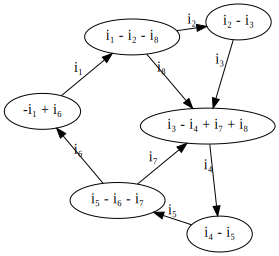

In [38]:
labels(g, edges=i, nodes=A'*i)

Why is this?  The reason is that each row $A^T$ corresponds to a node, and has $\pm 1$ for each edge going into or out of the node, exactly the right sign to sum the net currents flowing in:

In [39]:
A'

6×8 Array{Int64,2}:
 -1   0   0   0   0   1   0   0
  0   0   0   0   1  -1  -1   0
  0   0   0   1  -1   0   0   0
  1  -1   0   0   0   0   0  -1
  0   1  -1   0   0   0   0   0
  0   0   1  -1   0   0   1   1

Putting it together, given voltages $v$, the net current flowing into each node is

$$
A^T Y A v
$$

The matrix $A^T Y A$ is a very special and important kind of matrix.  It is obviously **symmetric**, and later on in the course we will see that any matrix of this form is necessarily **positive semidefinite** (all pivots are ≥ 0).   Many important matrices in science, engineering, statistics, and other fields take on this special form.

If we multiply $A^T Y A$ together, not all of its specialness is apparent.  It is often better to leave it in "factored" form:

In [40]:
A' * Y * A

6×6 Array{SymPy.Sym,2}
[Y_1 + Y_6       -Y_6            0           -Y_1            0                
[                                                                             
[  -Y_6     Y_5 + Y_6 + Y_7    -Y_5            0             0              -Y
[                                                                             
[    0           -Y_5        Y_4 + Y_5         0             0              -Y
[                                                                             
[  -Y_1            0             0      Y_1 + Y_2 + Y_8    -Y_2             -Y
[                                                                             
[    0             0             0           -Y_2        Y_2 + Y_3          -Y
[                                                                             
[    0           -Y_7          -Y_4          -Y_8          -Y_3     Y_3 + Y_4 

0          ]
           ]
_7         ]
           ]
_4         ]
           ]
_8         ]
           ]
_3 

#### Null space

If we just say that the net current flowing into each node is zero, we get the equation:
$$
A^T Y A v = 0
$$
or $v \in N(A^T Y A) = N(A)$.

It is an amazing and important fact that $N(A^T Y A) = N(A)$!!  (You saw a version of this in homework.)   Why is this?  Clearly, if $Ax = 0$ then $A^T Y Ax=0$.  But what about the converse?  Here is a trick: if $A^T Y Ax =0$, then $x^T A^T Y A x=0 = (Ax)^T Y (Ax)$.  Let $y=Ax$.  It is easy to see that $y^T Y y = \sum_i Y_i y_i^2 = 0$ only if $y=0$, since all of the admittances $Y_i$ are positive.  (We will later say that $Y$ is a "positive-definite matrix".)  This means that $A^T Y Ax =0$ implies that $y=Ax=0$, which implies that $x \in N(A)$.

What is $N(A)$? The rank of $A$ is 5, so $N(A)$ must be **1-dimensional**.  A basis for it is:

In [41]:
nullspace(A)

6×1 Array{Float64,2}:
 0.408248
 0.408248
 0.408248
 0.408248
 0.408248
 0.408248

But this is, of course, just the space of vectors where **all voltages are equal**.   In hindsight, this should be obvious: if all the voltages are equal, then their difference are zero, and the currents are zero, and KCL is satisfied.

### Current sources

Of course, it is much more interesting to think about circuits when the currents are nonzero!

To do this, we must consider a **source term** in the equations, and in particular we could try to solve

$$
A^T Y A v = s
$$

for some $s\ne 0$.  What does $s$ represent?  It is precisely an **external source of current** flowing **into each node**.

For this to have a solution, however, we must have $s \in C(A^T Y A) = N(A^T Y A)^T = N(A)^T$ (since $A^T Y A$ is symmetric, the left and right nullspaces are equal).  We know a basis for $N(A)$ from above, so this boils down to:

$$
\begin{pmatrix} 1 & 1 & 1 & 1 & 1 & 1 \end{pmatrix} s = 0 = \sum_{i=1}^6 s_i
$$

That is, to have a solution, **all current that flows in must flow out**, so that the net current flowing into the circuit is zero.  This makes a lot of physical sense!

Just for fun, let's solve this circuit problem when the current is flowing **into node 1** and **out through node 2**, with slider controls for the 8 admittances:

In [42]:
twodigits(x) = round(x, 2)

twodigits (generic function with 1 method)

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₁",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₂",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₃",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₄",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₅",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₆",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₇",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(5.0, nactions=1),"Y₈",5.0,"5.0",Interact.OptionDict(DataStructures.OrderedDict("0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9,"1.0"=>1.0…),Dict(1.2=>"1.2",4.3=>"4.3",9.6=>"9.6",2.0=>"2.0",1.5=>"1.5",7.1=>"7.1",1.4=>"1.4",7.4=>"7.4",6.2=>"6.2",0.2=>"0.2"…)),Any[],Any[],true,"horizontal")

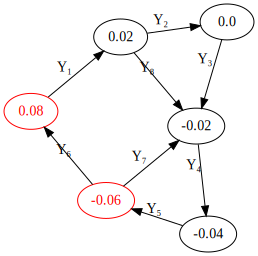

In [43]:
@manipulate for Y₁=0.1:0.1:10,
                Y₂=0.1:0.1:10,
                Y₃=0.1:0.1:10,
                Y₄=0.1:0.1:10,
                Y₅=0.1:0.1:10,
                Y₆=0.1:0.1:10,
                Y₇=0.1:0.1:10,
                Y₈=0.1:0.1:10
    s = [1,-1,0,0,0,0]
    Y = diagm([Y₁,Y₂,Y₃,Y₄,Y₅,Y₆,Y₇,Y₈])
    nodecolors!(labels(g, edges=[Sym("Y_$j") for j=1:size(A,1)],
                       nodes=twodigits.(pinv(A'*Y*A) * s)), [1,2])
end

Notice that if we make the admittance $Y_6$ really large compared to all of the other admittances, then nearly all of the current should flow just over that one edge.  Since (nearly) no current is flowing over the other edges, the other voltage drops are nearly zero (nearly constant voltages on the other nodes).

Hooray, math (and physics) works!

## Sparsity

The case of matrices arising from graphs illustrates another point that I've made many times: **really large matrices are often sparse (mostly 0)** in practice.

For example, imagine a circuit with a million nodes.  For the most part, there will only be *wires between nearby nodes*.  Or imagine a graph where the nodes are websites and the edges are links: there are billions of sites, but *each site only links to a few other sites* (a few hundred at most, usually).   In such cases, the **incidence matrix is mostly zero**, and similarly for $A^T Y A$ etcetetera.

This is hugely important, because solving $Ax=b$ and most other matrix equations scale as $\sim n^3$ for $n \times n$ matrices.  $1000 \times 1000$ matrices are easy (< 1 second), but $n=10^6$ would require supercomputers, and $n=10^9$ would be impossibly hard.   What saves us is that there are **much faster algorithms for sparse matrices**.  We won't learn much about such algorithms in 18.06, but the key point is to know that they exist.

If you encounter a large sparse matrix problem in the future, go read about sparse matrix algorithms!